<a href="https://colab.research.google.com/github/serg-kas/NN-archive/blob/main/%D0%90%D0%BF%D1%80%D0%B5%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D1%83%D1%80%D1%81_2020_Light_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_31_Object_Detection_(YOLOv3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание Light

Обернуть в функцию этапы распознавания изображения. На вход должно подаваться исходное изображение. На выходе должно быть исходное изображение со всеми найденными bounding_box.



# Подключение библиотек и Google диска


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization           # Стандартные слои Keras
from tensorflow.keras.layers import ZeroPadding2D, Add, UpSampling2D            # Стандартные слои Keras
from tensorflow.keras.layers import Concatenate, Lambda, LeakyReLU              # Стандартные слои Keras
from tensorflow.keras.regularizers import l2                                    # Регуляризатор
from tensorflow.keras.optimizers import Adam                                    # Оптимизатор
from tensorflow.keras.models import Model                                       # Model
import tensorflow as tf                                                         # TensorFlow
import tensorflow.keras.backend as K                                            # бэкенд Keras

import numpy as np                                                              # numpy массивы
import pandas as pd                                                             # Пандас для работы с csv
import math                                                                     # Импортируем модуль math
import time                                                                     # модуль работы со временем

from PIL import Image, ImageDraw, ImageFont                                     # Модули работы с изображениями
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb                            # Модули конвертации между RGB и HSV
import matplotlib.pyplot as plt                                                 # графики

import os                                                                       # Модуль работы с файловой системой
from google.colab import files                                                  # Модуль работы с файловой системой google

In [ ]:
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
drive.mount('/content/drive')

Mounted at /content/drive


# Глобальные параметры

In [ ]:
path = '/content/drive/My Drive/my_sample_data/Д.З.31/Самолеты/'           # Путь к директории на диске, где находятся изображения
name_classes = ['Самолеты']                                                # Названия классов
num_classes = len(name_classes)                                            # Количество классов
input_shape = (416, 416)                                                   # Размерность входного изображения для модели YOLO

# Массив используемых анкоров (в пикселях). Используетя по 3 анкора на каждый из 3 уровней сеток
# данные значения коррелируются с размерностью входного изображения input_shape
anchors = np.array([[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]]) 
num_anchors = len(anchors)                                                 # Сохраняем количество анкоров

# Создание модели

## Функции

In [ ]:
'''
    Функция создания полной модели
        Входные параметры:       
          input_shape - размерность входного изображения для модели YOLO
          num_anchors - общее количество анкоров   
          use_weights - использовать ли предобученные веса         
          weights_path - путь к сохраненным весам модели  
'''
def create_model(
        input_shape,
        num_anchors,
        use_weights = False, 
        weights_path = 'yolo.h5'        
        ):
    w, h = input_shape                      # Получаем ширину и высоту входного изображения
    inputs = Input(shape = (w, h, 3))       # Создаем входной слой модели, добавляя размерность для глубины цвета
    
    # Создаем три входных слоя y_true с размерностями ((None, 13, 13, 3, 6), (None, 26, 26, 3, 6) и (None, 52, 52, 3, 6))
    # 2 и 3 параметры (13, 13) указывают размерность сетки, на которую условно будет разбито исходное изображение
    # каждый уровень сетки отвечает за обнаружение объектов различных размеров (13 - крупных, 26 - средних, 52 - мелких)
    # 4 параметр - количество анкоров на каждый уровень сетки
    # 5 параметр - 4 параметра описывающие параметры анкора (координаты центра, ширина и высота) + вероятность обнаружения объекта + OHE номер класса
    y_true = [Input (shape = (w // 32, h // 32, num_anchors // 3, num_classes + 5))]            # Уровень сетки 13х13 (416/32)
    y_true.append (Input (shape = (w // 16, h // 16, num_anchors // 3, num_classes + 5)))       # Уровень сетки 26х26 (416/26)
    y_true.append (Input (shape = (w // 8, h // 8, num_anchors // 3, num_classes + 5)))         # Уровень сетки 52х52 (416/8)
    
    model_yolo = create_YOLOv3(inputs, num_anchors // 3)                                        # Создаем модель YOLOv3
    print ('Создана модель YOLOv3. Количество классов: {}.'.format(num_classes))                # Выводим сообщение о создании модели
    
    # Если установлен флаг загрузки весов
    if use_weights:
        model_yolo.load_weights(weights_path, by_name = False, skip_mismatch = False)           # Загружаем предобученные веса
        print ('Загружены веса из файла {}.'.format(weights_path))                              # Выводим сообщение о загруженных весах
        
    # Создаем выходной слой Lambda (выходом которого будет значение ошибки модели)
    # На вход слоя подается:
    #   - model_yolo.output (выход модели model_yolo (то есть то, что посчитала сеть))
    #   - y_true (оригинальные данные из обучающей выборки)
    outputs = Lambda(yolo_loss, output_shape = (1,), name = 'yolo_loss', arguments = {'num_anchors' : num_anchors}) ([*model_yolo.output, *y_true])
    
    return Model([inputs, *y_true], outputs)           # Возвращаем модель

In [ ]:
'''
Функция создания модели YOLOv3
    Входные параметры:
          inputs - Входной слой модели
          num_sub_anchors - количество анкоров в каждом уровне сеток
'''
def create_YOLOv3(
        inputs,
        num_sub_anchors
        ):
    #--------------------
    # Базовая часть модели YOLOv3
    #--------------------
    
    # Состоит из Conv2D-слоев и Residual-блоков. Residual-блок - это блок использующий информацию из предыдущих слоев.
    # С помощью слоя Add (Суммируется текущий слой и один из предыдущих), что позволяет избежать проблему потери информации
    # Количество resedual блоков и архитектура сети взята из документации YOLOv3
    x = ConvBL (inputs, 32, (3, 3))                 # Добавляем каскад из трех слоев (Conv2D, BatchNormalization и Leaky)
    x = resblock (x, 64, 1)                         # Добавляем 1 resedual-блок с 64 нейронами
    x = resblock (x, 128, 2)                        # Добавляем 2 resedual-блока с 128 нейронами
    x = resblock (x, 256, 8)                        # Добавляем 8 resedual-блоков с 256 нейронами
    x = resblock (x, 512, 8)                        # Добавляем 8 resedual-блоков с 512 нейронами
    x = resblock (x, 1024, 4)                       # Добавляем 4 resedual-блоков с 1024 нейронами
    base_model = Model(inputs, x)                   # Создаем базовую часть модели YOLOv3
    
    #--------------------
    # Detection часть модели YOLOv3
    #--------------------
    
    # Выделяем три выхода сети, соответсвующих различным уровням сетки
    
    
    # 13 x 13 (обнаружение больших объектов)
    x = ConvBL(base_model.output, 512, (1, 1))    
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    
    # Выделяем первый выход модели, соответствующий размерности 13 х 13
    y1 = ConvBL(x, 1024, (3,3))
    y1 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y1)
    
    
    # 26x26 (обнаружение средних объектов)
    
    # Размерность текущего выхода сети равна 13 х 13. Необходимо увеличить ее до 26 x 26 и
    # объеденить со 152-ым слоем (размерностью 26 x 26)
    x = ConvBL(x, 256, ( 1, 1)) 
    x = UpSampling2D(2) (x) # Увеличиваем размерность до 26 на 26, использую UpSampling
    x = Concatenate()([x,base_model.layers[152].output])
    
    # Добавляем 5 блоков ConvBL
    x = ConvBL(x, 256, (1, 1))  
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    
    # Выделяем второй выход модели, соответствующий размерности 26 х 26
    y2 = ConvBL(x, 512, (3, 3))
    y2 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y2)
    
    # 52 x 52 (обнаружение маленьких объектов)
    
    # Размерность текущего выхода сети равна 26 х 26. Необходимо увеличить ее до 52 x 52 и
    # объеденить со 92-ым слоем (размерностью 52 x 52)
    x = ConvBL(x, 128, ( 1, 1)) 
    x = UpSampling2D(2) (x)                             # Увеличиваем размерность до 52 на 52, использую UpSampling
    x = Concatenate()([x,base_model.layers[92].output])
    
    # Добавляем 5 блоков ConvBL
    x = ConvBL(x, 128, (1, 1))  
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    
    # Выделяем третий выход модели, соответствующий размерности 52 х 52
    y3 = ConvBL(x, 256, (3, 3))
    y3 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y3)
    
    return Model(inputs, [y1, y2, y3]) # Возвращаем модель

In [ ]:
''' Функция создания Residual блока.
    Входные параметры:
          inputs - Стартовый слой, к которому добавляется Res-блок
          num_filters - количество нейронов
          num_blocks  - количество блоков 
 '''
def resblock(
        inputs,
        num_filters,
        num_blocks
        ):
    x = ZeroPadding2D(((1, 0), (1, 0)))(inputs)              # Увеличиваем размерность на один шаг влево и вверх
    x = ConvBL(x, num_filters, (3, 3), strides=(2, 2))       # Добавляем блок ConvBL
    for i in range(num_blocks):                             # Пробегаем в цикле num_blocks-раз (суммируя слои с помощью Add())
        y = ConvBL(x, num_filters // 2, (1, 1))
        y = ConvBL(y, num_filters, (3, 3))
        x = Add() ([x, y])
    return x # Возвращаем слой

In [ ]:
''' Функция создания блока Conv2D, BatchNormalization, LeakyRelu
    Входные параметры:
          inputs - Стартовый слой, к которому добавляется Res-блок
          args - массив неименованных параметров
          kwargs  - массив именованных параметров
 '''
def ConvBL(
        inputs,
        *args,
        **kwargs
        ): 
    new_kwargs = {'use_bias': False}                    # создаем новый массив именованных параметров, добавляя параметр use_bias
    new_kwargs['kernel_regularizer'] = l2(5e-4)         # добавляем параметр kernel_regularizerpadding
    new_kwargs['padding'] = 'valid' if kwargs.get('strides') == (2, 2) else 'same' # добавляем параметр  padding
    new_kwargs.update(kwargs)                           # Добавляем уже имеющиеся в kwargs gfhfvtnhs
    x = Conv2D(*args, **new_kwargs) (inputs)            # Добавляем Conv2D слой
    x = BatchNormalization() (x)                        # Добавляем слой BatchNormalization
    x = LeakyReLU(alpha=0.1) (x)                        # Добавляем слой LeakyRelu
    return x

In [ ]:
'''
Функция подсчета ошибки.
    Входные параметры:
        inputs - Входные данные
        num_anchors - общее количество анкоров                    
'''
def yolo_loss(
      inputs,
      num_anchors
      ):
    ignore_thresh = .5                                  # Порог вероятности обнаружения объекта
    num_layers = num_anchors // 3                       # Подсчитываем количество анкоров на каждом уровне сетки
    y_pred = inputs[:num_layers]                        # Из входных данных выцепляем посчитанные моделью значения
    y_true = inputs[num_layers:]                        # Из входных данных выцепляем эталонные значения
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]     # Задаем маску анкоров для каждого уровня сеток
   
    
    # Получаем размерность входного изображения ( (13 х 13) * 32 = (416 х 416)) и приводим к типу элемента y_true[0]
    input_shape = K.cast(K.shape(y_pred[0])[1:3] * 32, K.dtype(y_true[0])) 
    
    # Получаем двумерный массив, соответствующий размерностям сеток ((13, 13), (26, 26), (52, 52))
    grid_shapes = [K.cast(K.shape(y_pred[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
    
    loss = 0 # Значение ошибки
    
    # Считываем количество элементов
    m = K.shape(y_pred[0])[0] # Размер пакета
    batch_size = K.cast(m, K.dtype(y_pred[0])) # Преобразуем к типу y_pred[0]
    
    for l in range(num_layers): # Пробегаем по всем трем уровням сеток
        # Получаем маску для сетки l-го уровня по вероятности определения объекта (5-ый параметр в списке общих параметров). 
        # В массиве object_mask будут значения, которые соответствуют только вероятности обнаружения объекта
        object_mask = y_true[l][..., 4:5]      # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        # Получаем аналогичную выборку для сетки l-го уровня с OHE (где записана позиция нашего класса)
        # В массиве true_class будут значения, которые соответсвуют только OHE представлению класса ядля данного уровня анкоров
        true_class = y_true[l][..., 5:]        # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        num_sub_anchors = len(anchors[anchor_mask[l]]) # Получаем количество анкоров для отдельного уровня сетки (3)
        
        # Решейпим анкоры отдельного уровня сетки и записываем в переменную anchors_tensor
        anchors_tensor = K.reshape(K.constant(anchors[anchor_mask[l]]), [1, 1, 1, num_sub_anchors, 2])
        
        # Создаем двумерный массив grid со значениями [[[0, 0] , [0, 1] , [0, 2] , ... , [0, k]], 
        #                                             [[1, 0] , [1, 1] , [1, 2] , ... , [1 ,k]],
        #                                             ...
        #                                             [[k, 0] , [k, 1] , [k, 2] , ... , [k, k]]]
        # где k - размерность сетки. Массив хранит индексы ячеек сетки
        grid_shape = K.shape(y_pred[l])[1:3]          # Получаем ширину и высоту сетки
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),[1, grid_shape[1], 1, 1]) # Создаем вертикальную линию
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),[grid_shape[0], 1, 1, 1]) # Создаем горизонтальную линию
        grid = K.concatenate([grid_x, grid_y])        # Объединяем 
        grid = K.cast(grid, K.dtype(y_pred[l]))       # Приводим к типу y_pred[l]
        
        # Решейпим y_pred[l]
        feats = K.reshape(y_pred[l], [-1, grid_shape[0], grid_shape[1], num_sub_anchors, num_classes + 5]) 
        
        # Считаем ошибку в определении координат центра объекта
        # Получаем координаты центра объекта из спредиктенного значения
        pred_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычисления для оригинальных значений из y_true для координат центра объекта
        true_xy = y_true[l][..., :2] * grid_shapes[l][::-1] - grid   # Реальные координаты центра bounding_box
        box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4] # чем больше бокс, тем меньше ошибка
        # binary_crossentropy для истинного значения и спредиктенного (obect_mask для подсчета только требуемого значения)
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(true_xy, feats[...,0:2], from_logits=True)

        # Считаем ошибку в определении координат ширины и высоты
        # Получаем значения ширины и высоты изображения из спредиктенного значения   
        pred_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычесления для оригинальных значений из y_true для ширины и высоты объекта
        true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1]) 
        # Оставляем значение высоты и ширины только у тех элементов, где object_mask = 1
        true_wh = K.switch(object_mask, true_wh, K.zeros_like(true_wh)) 
        # Считаем значение ошибки в определении высоты и ширины
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(true_wh-feats[...,2:4])
        
        # Объединяем значения в один  массив
        pred_box = K.concatenate([pred_xy, pred_wh]) 
        
        # Считаем ошибку в определении обнаружения какого-либо класса
        # Для этого вначале надо отсечь все найденные объекты, вероятность которых меньше установленного значения ignore_thresh
        
        # Определяем массив, который будет хранить данные о неподходящих значениях
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True) 
        object_mask_bool = K.cast(object_mask, 'bool') # Приводим тип object_mask к типу 'bool'
        
        # Функция, определяющая данные, которые требуется игнорировать
        # Пробегаем по всем элементам пакета (b<m)
        # Получаем параметры реального bounding_box для текущей ячейки
        # Считаем IoU реального и спредиктенного
        # В зависимости от best_iou < ignore_thresh помечаем его как верно распознанный или неверено
        def loop_body(
                b,
                ignore_mask
                ):
            # в true_box запишутся первыые 4 параметра (центр, высота и ширина объекта) того элемента, значение которого в object_mask_bool равно True
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0]) 
            # Подсчитываем iou для спредиктенной ограничивающей рамки (pred_box) и оригинальной (true_box)
            iou = calc_iou(pred_box[b], true_box) 
            # Находим лучшую ограничивающую рамку
            best_iou = K.max(iou, axis=-1) 
            # Записываем в ignore_mask true или false в зависимости от (best_iou < ignore_thresh)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou < ignore_thresh, K.dtype(true_box))) 
            return b+1, ignore_mask       # Увеличиваем счетчик на еденицу и возвращаем ignore_mask
        
        # Пробегаем в цикле по всем элементам в пределах значения m (m = batch size)
        _, ignore_mask = tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask]) 
        ignore_mask = ignore_mask.stack() # Приводим ignore_mask к тензору
        ignore_mask = K.expand_dims(ignore_mask, -1) # Добавляем еще одну размерность в конце ignore_mask
                 
        # Считаем значение ошибки
        # 1 компонента - для значений, которые были верно спредиктены
        # 2 компонентя - для значения, которые были неверно спредиктены
        confidence_loss = (
            object_mask * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) +
            (1-object_mask) * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) * ignore_mask
            )
        
        # Считаем ошибку в определении класса объекта
        class_loss = object_mask * K.binary_crossentropy(true_class, feats[...,5:], from_logits=True)
    
        # Считаем суммарную ошибку
        xy_loss = K.sum(xy_loss) / batch_size
        wh_loss = K.sum(wh_loss) / batch_size
        confidence_loss = K.sum(confidence_loss) / batch_size
        class_loss = K.sum(class_loss) / batch_size
        loss += xy_loss + wh_loss + confidence_loss + class_loss
                
    return loss # Возвращаем значение ошибки   

In [ ]:
'''
    Функция подсчета IoU
'''
def calc_iou(input1, input2):
    input1 = K.expand_dims(input1, -2)        # Добавляем одну размерность
    xy1 = input1[..., :2]                     # Получаем координаты x,y центра 
    wh1 = input1[..., 2:4]                    # Получаем значения высоты и ширины
    wh_half1 = wh1 / 2.                       # Делим значения высоты и ширины пополам
    top_left1 = xy1 - wh_half1                # Получаем значение, соответствующее верхнему левому углу
    right_bottom1 = xy1 + wh_half1            # Получаем значение, соотвествующее правому нижнему углу
    
    input2 = K.expand_dims(input2, 0)         # Добавляем одну размерность
    xy2 = input2[..., :2]                     # Получаем координаты x,y центра 
    wh2 = input2[..., 2:4]                    # Получаем значения высоты и ширины
    wh_half2 = wh2 / 2.                       # Делим значения высоты и ширины пополам
    top_left2 = xy2 - wh_half2                # Получаем значение, соответствующее верхнему левому углу
    right_bottom2 = xy2 + wh_half2            # Получаем значение, соотвествующее правому нижнему углу
    
    intersect_mins = K.maximum(top_left1, top_left2)                # Берем максимальные координаты из левых верхних углов
    intersect_maxes = K.minimum(right_bottom1, right_bottom2)       # Берем Минимальные координаты координаты из правых нижних углов
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)  # Считаем ширину и высоту области пересечения
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]    # Считаем площадь области пересечения
    
    area1 = wh1[..., 0] * wh1[..., 1]         # Считаем площадь первых элементов
    area2 = wh2[..., 0] * wh2[..., 1]         # Считаем площадь вторых элементов
    
    return intersect_area / (area1 + area2 - intersect_area)        # Возвращаем IoU
    

## Основной код

In [ ]:
# Создаем модель
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=path +'weights/YOLOv3__el1000__opt0.0001__ep0_100.h5')

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/my_sample_data/Д.З.31/Самолеты/weights/YOLOv3__el1000__opt0.0001__ep0_100.h5.


In [ ]:
# Выводим входные размерности для модели
model_YOLO.input

[<KerasTensor: shape=(None, 416, 416, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 13, 13, 3, 6) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 26, 26, 3, 6) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 52, 52, 3, 6) dtype=float32 (created by layer 'input_4')>]

In [ ]:
# Выводим выходную размерность модели
model_YOLO.output

<KerasTensor: shape=() dtype=float32 (created by layer 'yolo_loss')>

In [ ]:
# Выводим информацию о модели
model_YOLO.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

# Обнаружение объектов

**Готовим функцию, которая будет получать на вход путь к картинке и возвращать путь к обработанному (распознанному) изображению. Также передаем в функцию путь к весам модели**

In [ ]:
def predict_YOLO(img_path = '', new_img_path ='new_image.jpg', model_weight = '' ):

  # Выходим если нечего обрабатывать
  if img_path == '':
    print('Вы не дали картинку для обработки.')
    return

  # Выходим если нечего обрабатывать
  if model_weight == '':
    print('Нет данных для загрузки весов модели.')
    return

  # Файл с весами модели
  #model_weight = path + 'weights/YOLOv3__el1000__opt0.00001__ep0_100.h5'
  # Создаем модель
  model_YOLO = create_YOLOv3(Input(shape=(416, 416, 3)), 9//3) 
  # Загружаем посчитанные веса модели
  model_YOLO.load_weights(model_weight) 
  print ('{} загружены.'.format(model_weight))

  # Создаем набор цветов для ограничивающих рамок
  import colorsys 
  hsv_tuples = [(x / len(name_classes), 1., 1.) for x in range(len(name_classes))]
  colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
  colors = list(map(lambda x:(int(x[0]*255), int(x[1]*255), int(x[2]*255)), colors))
  np.random.seed(43)
  np.random.shuffle(colors)
  np.random.seed(None)

  # Берем изображение по заданному пути
  image = Image.open(img_path) 
  #plt.imshow(image)

  # Изменяем размер картинки под input_shape
  iw, ih = image.size
  w, h = (416, 416)
  scale = min(w / iw, h / ih)
  nw = int(iw * scale)
  nh = int(ih * scale)
  image_for_predict = image.resize((nw, nh), Image.BICUBIC)
  new_image = Image.new('RGB', (416,416), (128, 128, 128))
  new_image.paste(image_for_predict, ((w - nw) // 2, (h - nh) // 2))
  image_for_predict = new_image 
  image_for_predict = np.array(image_for_predict) / 255.
  #plt.imshow(image_for_predict)
  image_for_predict = image_for_predict.reshape(1, 416, 416, 3)
  #print (image_for_predict.shape)

  # Получаем предикт
  predict = model_YOLO.predict(image_for_predict)
  num_layers = len(predict)                              # Получаем количество сеток
  anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]              # Задаем маски для 3 уровней анкоров
  input_shape = np.array(predict[0].shape[1:3]) * 32     # Получаем размер выходного изображения
  image_shape = np.array([image.size[1], image.size[0]]) # Сохраняем размер оригинального изображения
  #print(input_shape)
  #print(image_shape)

  level_anchor = 0                                       # Укажем уровень сетки
  num_anchors = len(anchors[anchor_mask[level_anchor]])  # Получаем количество анкоров
  anchors_tensor = np.reshape(anchors[anchor_mask[level_anchor]], (1,1,1,num_anchors,2)) # Выбираем анкоры для нашего уровня сетки и решейпим
  #print(anchors_tensor.shape)
  #print(anchors_tensor)

  grid_shape = predict[level_anchor].shape[1:3]          # Получим размерность сетки
  grid = []                                              # Массив для финальной сетки
  grid_row = []                                          # Массив для столбца
  for i in range(grid_shape[0]):                         # По всем строкам
    for j in range(grid_shape[1]):                       # По всем столбцам
      grid_row.append([j , i])                           # Создаем элемент [j, i]
    grid.append(grid_row)                                # Добавляем столбец в финальную сетку
    grid_row = []                                        # Обнуляем данные для столбца
  grid = np.array(grid)                                  # Переводим в numpy
  grid = np.expand_dims(grid, axis=2)                    # Добавляем размерность
  #print(grid.shape)                                     

  # Решейпим предикт
  feats = np.reshape(predict[level_anchor], (-1, grid_shape[0], grid_shape[1], num_anchors, num_classes+5))
  #print(feats.shape)

  # Функция расчета сигмоиды для вектора
  def sigmoid(x):           # На вход подаем массив данных
    return 1/(1+np.exp(-x)) # Возвращаем сигмоиду для всех элементов массива

  # Получаем параметры бокса
  # Координаты центра bounding box
  xy_param = feats[..., :2] # Выцепляем 0 и 1 параметры из предикта (соответствуют параметрам смещения центра анкора)
  box_xy = (sigmoid(xy_param) + grid)/grid_shape[::-1] # Получаем координаты центра bounding box

  # Высота и ширна bounding box
  wh_param = feats[..., 2:4] # Выцепляем 2 и 3 параметры из предикта (соответствуют праметрам изменения высоты и ширины анкора)
  box_wh = np.exp(wh_param) * anchors_tensor / input_shape[::-1] # Получаем высоту и ширину bounding box

  # Вероятность наличия объекта в анкоре
  conf_param = feats[..., 4:5] # Выцепляем 4 параметр из предикта (соответствуют вероятности обнаружения объекта)
  box_confidence = sigmoid(conf_param) # Получаем вероятность наличия объекта в bounding box

  # Класс объекта
  class_param = feats[...,5:] # Выцепляем 5+ параметры из предикта (соответствуют вероятностям классов объектов)
  box_class_probs = sigmoid(class_param) # Получаем вероятности классов объектов
  #print(box_xy.shape)
  #print(box_wh.shape)
  #print(box_confidence.shape)
  #print(box_class_probs.shape)

  # Корректируем ограничивающие рамки (Размер изображения на выходе 416х416)
  # И найденные параметры соответствуют именно этой размерности
  # Необходимо найти координаты bounding box для рамерности исходного изображения
  box_yx = box_xy[..., ::-1].copy()
  box_hw = box_wh[..., ::-1].copy()

  new_shape = np.round(image_shape * np.min(input_shape/image_shape)) # Находим размерность пропорциональную исходной с одной из сторон 416
  offset = (input_shape-new_shape)/2./input_shape # Смотрим на сколько надо сместить в относительных координатах
  scale = input_shape/new_shape  # Находим коэфициент масштабирования
  box_yx = (box_yx - offset) * scale # Смещаем по координатам
  box_hw *= scale # Масштабируем ширину и высоту

  box_mins = box_yx - (box_hw / 2.) # Получаем левые верхние координаты (от середины отнимаем половину ширины и высоты)
  box_maxes = box_yx + (box_hw / 2.) # Получаем правые нижнние координаты (к середине прибавляем половину ширины и высоты)
  _boxes =  np.concatenate([
      box_mins[..., 0:1], # yMin
      box_mins[..., 1:2], # xMin
      box_maxes[..., 0:1], # yMax
      box_maxes[..., 1:2]  # xMax
  ], axis=-1)
  #print(new_shape)
  #print(offset)
  #print(scale)
  #print(_boxes.shape)
  #print()
  #print(_boxes[0][6][7][1])
  #print(image_shape)
  _boxes *= np.concatenate([image_shape, image_shape]) # Переводим из относительных координат в абсолютные
  
  # Получаем выходные параметры
  _boxes_reshape = np.reshape(_boxes, (-1, 4))                     # Решейпим все боксы в один массив
  _box_scores = box_confidence * box_class_probs         # Получаем вероятность каждого класса (умноженную на веоятность наличия объекта)
  _box_scores_reshape = np.reshape(_box_scores, (-1, num_classes)) # Решейпим в один массив
  #print(_boxes_reshape.shape)
  #print(_box_scores_reshape.shape)
  #print(_boxes_reshape[256])
  #print(_box_scores_reshape[256]) # Вероятность того, что объект 0-го класса

  # Берем все объекты, обнаруженные с вероятностью больше 0.7
  mask = _box_scores_reshape >= 0.7 
  #print(np.where(mask == True))

  _boxes_out = _boxes_reshape[mask[:,0]]
  _scores_out = _box_scores_reshape[:, 0][mask[:,0]] 
  classes_out = np.ones_like(_scores_out,'int32') * 0
  #print(_boxes_out)
  #print(_scores_out)
  #print (classes_out)

  font = ImageFont.truetype(font=path + 'font.otf',
                      size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
  thickness = (image.size[0] + image.size[1]) // 300
  

  # Non-maximum Suppression
  def non_max_suppression_fast(boxes, scores, overlapThresh):	
    if len(boxes) == 0:        # Если нет ни одного бокса
      return []

    pick = [] # Индексы возвращаемых боксов
  
    x1 = boxes[:,0] # координаты x левыъ верхних углов
    y1 = boxes[:,1] 
    x2 = boxes[:,2]
    y2 = boxes[:,3]
  
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)
  
    while len(idxs) > 0:
      last = len(idxs) - 1
      i = idxs[last]
      pick.append(i)
    
      xx1 = np.maximum(x1[i], x1[idxs[:last]])
      yy1 = np.maximum(y1[i], y1[idxs[:last]])
      xx2 = np.minimum(x2[i], x2[idxs[:last]])
      yy2 = np.minimum(y2[i], y2[idxs[:last]])
    
      w = np.maximum(0, xx2 - xx1 + 1)
      h = np.maximum(0, yy2 - yy1 + 1)
    
      overlap = (w * h) / area[idxs[:last]]
      idxs = np.delete(idxs, np.concatenate(([last],
                                             np.where(overlap > overlapThresh)[0])))
  
    return boxes[pick].astype("int"), scores[pick]

  new_boxes, new_scores = non_max_suppression_fast(_boxes_out, _scores_out, 0.15)
  new_classes = np.ones_like(new_scores,'int32') * 0
  #print(new_boxes)

  image_pred = image.copy()
  for i, c in reversed(list(enumerate(new_classes))):
    draw = ImageDraw.Draw(image_pred)
    predicted_class = name_classes[c]
    box = new_boxes[i]
    score = new_scores[i]

    label = '{} {:.2f}'.format(predicted_class, score)
    label_size = draw.textsize(label, font)

    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
    right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
    #print(label, (left, top), (right, bottom))

    if top - label_size[1] >= 0:
        text_origin = np.array([left, top - label_size[1]])
    else:
        text_origin = np.array([left, top + 1])
  
    for i in range(thickness):
        draw.rectangle(
            [left + i, top + i, right - i, bottom - i],
            outline=colors[c])
    draw.rectangle(
        [tuple(text_origin), tuple(text_origin + label_size)],
        fill=colors[c])
    draw.text(text_origin, label, fill=(0, 0, 0), font=font)
    del draw
  image_pred.save(new_img_path)
  #plt.imshow(image_pred)

  return new_img_path

/content/drive/My Drive/my_sample_data/Д.З.31/Самолеты/weights/YOLOv3__el1000__opt0.00001__ep0_100.h5 загружены.


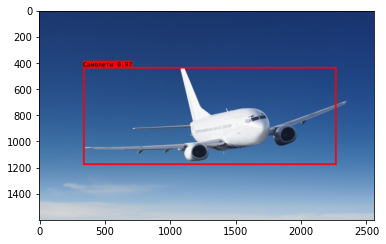

In [ ]:
# Берем картинку из тестовой папки и подаем в функцию
model_weight = path + 'weights/YOLOv3__el1000__opt0.00001__ep0_100.h5'
new_img_path = predict_YOLO(path+'test/plane2.jpg', 'first_plane.jpg', model_weight )
new_img = Image.open(new_img_path)
plt.imshow(new_img)

/content/drive/My Drive/my_sample_data/Д.З.31/Самолеты/weights/YOLOv3__el1000__opt0.00001__ep0_100.h5 загружены.


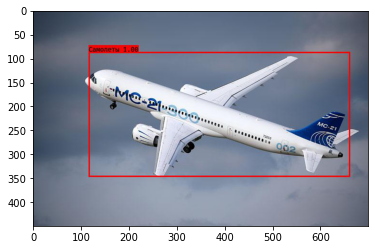

In [ ]:
# Берем картинку из тестовой папки и подаем в функцию
model_weight = path + 'weights/YOLOv3__el1000__opt0.00001__ep0_100.h5'
new_img_path = predict_YOLO(path+'test/plane3.jpg', 'second_plane.jpg', model_weight)
new_img = Image.open(new_img_path)
plt.imshow(new_img)


# Задание Pro

Проверить гипотезу.
1. Необходимо провести обучение модели (YOLOv3 или RetinaNet) на уменьшенной выборке (взять неполную базу самолетов из 1000 элементов, а 50-100 элементов). Проанализировать изменение ошибки и оценить насколько эти данные коррелируются с ошибкой на полной базе. Оценить на сколько снизилось время обучения.
2. В случае успешного подтверждения теории (то есть падение ошибки на уменьшенной базе соответствует падению ошибки на полной базе): добиться минимального значения ошибки на неполной базе. Провести обучение сети на измененных данных для полной базы (200-300 эпох) и проверить результаты.


# Обучение модели на уменьшенной базе

## Функции

In [ ]:
# Функция генерации данных
def data_generator(annotation_lines, batch_size, anchors, input_shape):
    n = len(annotation_lines)                                 # Получаем количество элементов в словаре аннотаций
    i = 0                                                     # Задаем начальный индекс
    while True:
        image_data = []                                       # Массив для хранения изображений 416х416
        box_data = []                                         # Массив для хранения bounding_box данных
        for b in range(batch_size):                           # Пробегаем по всему batch_size
            if i==0:                                          # Если первая итерация цикла
                np.random.shuffle(annotation_lines)           # Перемешиваем элементы
            image, box = augmentation(annotation_lines[i])    # Делаем аугментацию картинок и ограничивающих рамок
            image_data.append(image)                          # Добавляем полученную картинку в результирующий массив 
            box_data.append(box)                              # Добавляем полученную ограничивающую рамку в массив bounfing_box
            i = (i+1) % n                                     # Обновляем значение индека (не превышая общего количества элементов)
        image_data = np.array(image_data)                     # Преобразуем в numpy
        box_data = np.array(box_data)                         # Преобразуем в numpy
        y_true = get_y(box_data, anchors, input_shape)        # По значению ограничивающей рамки получаем y_true        
        yield [image_data, *y_true], np.zeros(batch_size)     # Возвращаем порцию данных для обучения

In [ ]:
# Случайная аугментация изображения
def augmentation(data):
    # Словарь с параметрами аугментации
    params = {
        'jitter' : .3,
        'hue'    : .1,
        'sat'    : 1.5,
        'val'    : 1.5
    }
    
    data = data.split()                                       # Сплитим входную строку словаря
    image = Image.open(path + data[0])                        # Открываем изображение самолета
    width_i, height_i = image.size                            # Получаем ширину и высоту оригинального изображения
    widht_shape, height_shape = input_shape[:2]               # Получаем ширину и высоту входного изображения для модели RetinaNet
    
    # Получаем координаты ограничивающей рамки
    box = np.array([np.array(list(map(lambda x: int(float(x)),box.split(',')))) for box in data[1:]])
    
    # Случайным образом масштабируем изображение
    new_ar = widht_shape / height_shape * rand(1 - params['jitter'], 1 + params['jitter']) / rand(1 - params['jitter'], 1 + params['jitter'])
    scale = rand(.65, 2) 
    if new_ar < 1:        
        nh = int(scale * height_shape)
        nw = int(nh * new_ar)
    else:
        nw = int(scale * widht_shape)
        nh = int(nw / new_ar)
    image = image.resize((nw, nh), Image.BICUBIC)
    
    # Преобразуем картинку к input_shape и размещаем случайным образом
    dx = int(rand(0, widht_shape - nw))
    dy = int(rand(0, height_shape - nh))
    new_image = Image.new('RGB', (widht_shape, height_shape), (128,128,128))
    new_image.paste(image, (dx, dy))
    image = new_image
    
    # С вероятностью 50% отображаем по горизонтале
    flip = rand() < .5
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Случайным образом меняем освещенность, экспозицию, гамму изображения
    hue1 = rand(-params['hue'], params['hue'])
    sat1 = rand(1, params['sat']) if rand() < .5 else 1 / rand(1, params['sat'])
    val1 = rand(1, params['val']) if rand() < .5 else 1 / rand(1, params['val'])
    x = rgb_to_hsv(np.array(image) / 255.)
    x[..., 0] += hue1
    x[..., 0][x[..., 0] > 1] -= 1
    x[..., 0][x[..., 0] < 0] += 1
    x[..., 1] *= sat1
    x[..., 2] *= val1
    x[x > 1] = 1
    x[x < 0] = 0
    image_data = hsv_to_rgb(x) # Получаем окончательный массив
    
    max_boxes = 4 # Устанавливаем максимальное количество рамок на изображении
    # Корректируем параметры ограничивающей рамки в соответсвии с проведенными выше преобразованиями
    box_data = np.zeros((max_boxes,5)) # Создаем массив из нулей размерностью (max_boxes, 5) 
    if len(box)>0:                
        # Ресайзим и перемещаем
        box[:, [0,2]] = box[:, [0,2]] * nw/width_i + dx
        box[:, [1,3]] = box[:, [1,3]] * nh/height_i + dy
        # Отражаем по горизонтале
        if flip: box[:, [0,2]] = widht_shape - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        # Ограничиваем, если вышли за пределы input_shape
        box[:, 2][box[:, 2] > widht_shape] = widht_shape
        box[:, 3][box[:, 3] > height_shape] = height_shape
        # Считаем высоту и ширину рамок и оставляем только те, значения которых больше 1
        box_w = box[:, 2] - box[:, 0]                           # xRight - xLeft
        box_h = box[:, 3] - box[:, 1]                           # yBottom - yTop
        box = box[np.logical_and(box_w > 1, box_h > 1)]
        if len(box) > max_boxes:                                # Оставляем только max_boxes рамок
            box = box[:max_boxes]
        box_data[:len(box)] = box                               # Записываем данные в box_data
    
    # Возвращаем изменные изображение и ограничивающую рамку
    return image_data, box_data # Возвращаем аугментированные изображение и bounding_box

In [ ]:
# Функция подсчета y
def get_y(true_boxes, anchors, input_shape):
    num_layers = len(anchors) // 3                                # Получаем количество анкоров для каждого уровня сеток
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]                     # Задаем маску анкоров для каждого уровня

    true_boxes = np.array(true_boxes, dtype='float32')            # Преобразуем bounding_box в numpy
    input_shape = np.array(input_shape, dtype='int32')            # Преобразуем input_shape в numpy
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 # Получаем координаты центра bounding_box (xRight+xLeft / 2)
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]        # Получаем ширину и высоту bounding_box (xRight - xLeft)
    true_boxes[..., 0:2] = boxes_xy / input_shape[::-1]           # Получаем координаты центра bounding_box в относительных координатах
    true_boxes[..., 2:4] = boxes_wh / input_shape[::-1]           # Получаем высоту и ширину bounding_box В относительных значениях

    m = true_boxes.shape[0]                                       # Получаем количество элементов в batch_size
    # Создаем список из трех элементов ([13, 13], [26, 26], [52, 52])
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)] 

    # Создаем 0-вые списки для y_true
    # y_true[0].shape = (None, 13, 13, 3, 6)
    # y_true[1].shape = (None, 26, 26, 3, 6)
    # y_true[2].shape = (None, 52, 52, 3, 6)
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]

    # Добавляем размерность
    anchors = np.expand_dims(anchors, 0)  

    # Параметры для IoU
    anchor_maxes = anchors / 2. 
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0] > 0

    for b in range(m):
        wh = boxes_wh[b, valid_mask[b]]                            # Получаем ширину и высоту текущего bounding_box
        if len(wh)==0: continue                                    # Выходим если она нулевая
        wh = np.expand_dims(wh, -2)                                # Добавляем размерность
        
        # Параметры для IoU
        box_maxes = wh / 2.
        box_mins = -box_maxes
        
        intersect_mins = np.maximum(box_mins, anchor_mins) 
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        best_anchor = np.argmax(iou, axis=-1)                      # Находим лучшее значение iou для всех анкоров 

        for t, n in enumerate(best_anchor): 
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0] * grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1] * grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1
    return y_true

In [ ]:
# Получение координат ограничивающей рамки
def getXY(image):
    image_red = np.array(image)[:,:,0]                # Считываем красный канал изображения
    indexes = np.where(image_red > 20)                # Получаем индексы пискселей красного цвета
    
    # Возвращаем координаты ограничивающей рамки [Xmin, Ymin, Xmax, Ymax]
    return [min(indexes[1]), min(indexes[0]), max(indexes[1]), max(indexes[0]) ]

# Создание словаря {Имя файла: параметры файла}
def get_dict(n_max = 1000):                           # СКОЛЬКО ФАЙЛОВ ИСПОЛЬЗОВАТЬ МАКСИМАЛЬНО
    n_curr = 0                                        # СЧИТАЕМ СКОЛЬКО ФАЙЛОВ ВЗЯЛИ
    dictionary = {}                                   # Создаем пустой словарь
    files = os.listdir(path + 'Segment/')             # Получаем список файлов
    class_id = 0                                      # Задаем параметр номера класса (у нас всего один класс "Самолет")
    for f in files:
        if n_curr >= n_max:                           # ВЫХОДИМ ЕСЛИ ВЗЯЛИ ДОСТАТОЧНОЕ КОЛИЧЕСТВО ФАЙЛОВ
          break

        image = Image.open(path + 'Segment/'+f)       # Открываем сегментированное изображение
        xy = getXY(image)                             # Получаем координаты ограничивающей рамки
        key = f                                       # Получаем ключ словаря (имя файла)

        n_curr += 1                                   # ДОБАВЛЯЕМ СЧЕТЧИК

        # Записываем значение в словарь
        dictionary[key] = 'Самолеты/'+key+' ' +str (xy[0]) +',' + str(xy[1])+','+str(xy[2])+','+str(xy[3])+','+str(class_id)

    print ('Завершена обработка класса: ', name_classes[0]) # Выводим сообщение о заврешении обработки
        
    return dictionary # Возвращаем словарь

def rand(a=0, b=1):
    return np.random.rand()*(b-a) + a

## Подготовка данных

**Функция подготовки словаря аннотаций теперь получает параметр сколько файлов брать максимально**

In [ ]:
# Создаем словарь аннотаций (Формат: Имя_файла Xmin,Ymin,Xmax,Ymax,class_id)
startTime = time.time()        # Засекаем время старта процесса создания словаря
dictionary = get_dict(77)      # Вызываем функцию создания словаря

# Выводим сообщение о создании словаря и время, потраченное на создание словаря
print ('Словарь аннотаций создан! Время создания словаря:'+str(round(time.time() - startTime)) +'сек')

Завершена обработка класса:  Самолеты
Словарь аннотаций создан! Время создания словаря:39сек


In [ ]:
print ('Количество изображений:', len(dictionary))     # Отображаем количество элементов в словаре

Количество изображений: 77


In [ ]:
dictionary_np = np.array(list(dictionary.values()))    #Создаем numpy массив из значений словаря

# Выведем информацию из словаря и из его numpy представления
print (dictionary['airplane_2.jpg'])
print(dictionary_np[0])

Самолеты/airplane_2.jpg 210,266,1715,742,0
Самолеты/airplane_1.jpg 253,336,1653,666,0


In [ ]:
val_split = 0.1                           # Коэфициент разделения на обучающую и проверочную выборку

# Перемешаем значения в массиве
np.random.seed(17)
np.random.shuffle(dictionary_np)
np.random.seed(None)

num_val = int(len(dictionary_np) * val_split)  # Количество элементов проверочной выборки
num_train = len(dictionary_np) - num_val       # Количество элементов обучающей выборки
print (num_val)
print (num_train)

7
70


## Обучение с различными шагами


In [ ]:
# ПОТРЕБУЕТСЯ ДРУГОЙ ПУТЬ ДЛЯ СОХРАНЕНИЯ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ
NEW_path = '/content/drive/My Drive/my_sample_data/Д.З.31/Pro100/'  

### lr_value = 1e-3

#### Первые 100 эпох

In [ ]:
lr_value = 1e-3 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss': lambda y_true, y_pred: y_pred})

In [ ]:
startTime = time.time()          # Засекаем время начала процесса обучения
batch_size = 8                   # Задаем размер пакета
model_filename = NEW_path +'weights/YOLO/YOLOv3__el1000__opt0.001__ep0_100.h5' # Указываем имя файла для сохранения модели
# Запускаем процесс обучения на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 100,
                    verbose = 1,
                    initial_epoch = 0
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss'])                   # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss'])           # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(NEW_path+'csv/YOLO/loss__el1000_opt0.001__ep0_100.csv')        # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(NEW_path+'csv/YOLO/valloss__el1000_opt0.001__ep0_100.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
8/8 [==============================] - 45s 4s/step - loss: 3.0215 - val_loss: 18.4192
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 3.0702 - val_loss: 510.9526
Epoch 3/100
8/8 [==============================] - 8s 1s/step - loss: 3.2746 - val_loss: 681.4598
Epoch 4/100
8/8 [==============================] - 8s 1s/step - loss: 2.8334 - val_loss: 51.2222
Epoch 5/100
8/8 [==============================] - 8s 1s/step - loss: 3.1913 - val_loss: 40.4699
Epoch 6/100
8/8 [==============================] - 9s 1s/step - loss: 3.2439 - val_loss: 124.1878
Epoch 7/100
8/8 [==============================] - 8s 1s/step - loss: 3.5329 - val_loss: 26.6081
Epoch 8/100
8/8 [==============================] - 8s 1s/step - loss: 2.8145 - val_loss: 19.3806
Epoch 9/100
8/8 [==============================] - 8s 1s/step - loss: 2.5553 - val_loss: 11.2993
Epoch 10/100
8/8 [==============================] - 8s 1s/step - loss: 2.8099 - val_loss: 22.6427
Epoch 11/100
8/8 [=======

**Прирост скорости обучения виден сразу. 8 секунд вместо 118 на эпоху; 100 эпох закончены за 875 секунд вместо 12500 секунд. Быстрее в 14 раз**

**Учим дальше и сохраняем результаты.**

#### Еще 100 эпох на текущем шаге

In [ ]:
#
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и  компилируем
#
model_weight =  NEW_path +'weights/YOLO/YOLOv3__el1000__opt0.001__ep0_100.h5' # Указываем файл с весами модели
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
lr_value = 1e-3 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/my_sample_data/Д.З.31/Pro100/weights/YOLO/YOLOv3__el1000__opt0.001__ep0_100.h5.


In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 8 #Задаем размер пакета
model_filename = NEW_path +'weights/YOLO/YOLOv3__el1000__opt0.001__ep100_200.h5' # Указываем имя файла для сохранения модели

# Запускаем процесс обучения еще на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 200,
                    verbose = 1,
                    initial_epoch = 100
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(NEW_path+'csv/YOLO/loss__el1000_opt0.001__ep100_200.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(NEW_path+'csv/YOLO/valloss__el1000_opt0.001__ep100_200.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 101/200
8/8 [==============================] - 20s 1s/step - loss: 2.7762 - val_loss: 8.7694
Epoch 102/200
8/8 [==============================] - 8s 1s/step - loss: 2.8540 - val_loss: 12.0035
Epoch 103/200
8/8 [==============================] - 8s 1s/step - loss: 2.8467 - val_loss: 5.1656
Epoch 104/200
8/8 [==============================] - 8s 1s/step - loss: 2.8658 - val_loss: 3.3139
Epoch 105/200
8/8 [==============================] - 8s 1s/step - loss: 2.8191 - val_loss: 10.1834
Epoch 106/200
8/8 [==============================] - 8s 1s/step - loss: 2.7905 - val_loss: 5.7286
Epoch 107/200
8/8 [==============================] - 8s 1s/step - loss: 2.6455 - val_loss: 6.3423
Epoch 108/200
8/8 [==============================] - 8s 1s/step - loss: 3.0807 - val_loss: 3.4610
Epoch 109/200
8/8 [==============================] - 8s 1s/step - loss: 3.0896 - val_loss: 11.0037
Epoch 110/200
8/8 [==============================] - 8s 1s/step - loss: 3.2800 - val_loss: 9.9627
Epoch 111/200
8/

### lr_value = 1e-4

#### Первые 100 эпох

In [ ]:
#
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и  компилируем
#

model_weight =  NEW_path +'weights/YOLO/YOLOv3__el1000__opt0.001__ep100_200.h5' # Указываем файл с весами модели
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
model_YOLO.load_weights(model_weight) # Загружаем посчитанные веса модели
lr_value = 1e-4 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/my_sample_data/Д.З.31/Pro100/weights/YOLO/YOLOv3__el1000__opt0.001__ep100_200.h5.


In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 8 #Задаем размер пакета
model_filename = NEW_path +'weights/YOLO/YOLOv3__el1000__opt0.0001__ep0_100.h5' # Указываем имя файла для сохранения модели

# Запускаем процесс обучения на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 100,
                    verbose = 1,
                    initial_epoch = 0
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(NEW_path+'csv/YOLO/loss__el1000_opt0.0001__ep0_100.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(NEW_path+'csv/YOLO/valloss__el1000_opt0.0001__ep0_100.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
8/8 [==============================] - 20s 1s/step - loss: 3.0716 - val_loss: 5.9649
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 2.6554 - val_loss: 5.6375
Epoch 3/100
8/8 [==============================] - 8s 1s/step - loss: 2.7129 - val_loss: 4.8173
Epoch 4/100
8/8 [==============================] - 8s 1s/step - loss: 2.6108 - val_loss: 4.7508
Epoch 5/100
8/8 [==============================] - 8s 1s/step - loss: 2.6847 - val_loss: 4.9284
Epoch 6/100
8/8 [==============================] - 8s 1s/step - loss: 2.4896 - val_loss: 3.6180
Epoch 7/100
8/8 [==============================] - 8s 1s/step - loss: 2.6208 - val_loss: 2.6534
Epoch 8/100
8/8 [==============================] - 8s 1s/step - loss: 2.5336 - val_loss: 2.5163
Epoch 9/100
8/8 [==============================] - 8s 1s/step - loss: 2.4286 - val_loss: 2.7835
Epoch 10/100
8/8 [==============================] - 8s 1s/step - loss: 2.5417 - val_loss: 2.6165
Epoch 11/100
8/8 [====================

#### Еще 100 эпох

In [ ]:
#
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и  компилируем
#
model_weight =  NEW_path +'weights/YOLO/YOLOv3__el1000__opt0.0001__ep0_100.h5' # Указываем файл с весами модели
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
model_YOLO.load_weights(model_weight) # Загружаем посчитанные веса модели
lr_value = 1e-4 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/my_sample_data/Д.З.31/Pro100/weights/YOLO/YOLOv3__el1000__opt0.0001__ep0_100.h5.


In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 8 #Задаем размер пакета
model_filename = NEW_path +'weights/YOLO/YOLOv3__el1000__opt0.0001__ep100_200.h5' # Указываем имя файла для сохранения модели

# Запускаем процесс обучения еще на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 200,
                    verbose = 1,
                    initial_epoch = 100
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(NEW_path+'csv/YOLO/loss__el1000_opt0.0001__ep100_200.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(NEW_path+'csv/YOLO/valloss__el1000_opt0.0001__ep100_200.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 101/200
8/8 [==============================] - 19s 1s/step - loss: 33.3205 - val_loss: 3.2366
Epoch 102/200
8/8 [==============================] - 8s 1s/step - loss: 3.2828 - val_loss: 3.4107
Epoch 103/200
8/8 [==============================] - 8s 1s/step - loss: 2.4832 - val_loss: 3.1916
Epoch 104/200
8/8 [==============================] - 8s 1s/step - loss: 2.2897 - val_loss: 3.1217
Epoch 105/200
8/8 [==============================] - 8s 1s/step - loss: 2.1945 - val_loss: 2.8432
Epoch 106/200
8/8 [==============================] - 8s 1s/step - loss: 2.1651 - val_loss: 5.3971
Epoch 107/200
8/8 [==============================] - 8s 1s/step - loss: 2.2610 - val_loss: 2.4606
Epoch 108/200
8/8 [==============================] - 8s 1s/step - loss: 2.3458 - val_loss: 2.5712
Epoch 109/200
8/8 [==============================] - 8s 1s/step - loss: 2.2835 - val_loss: 3.4266
Epoch 110/200
8/8 [==============================] - 8s 1s/step - loss: 2.3902 - val_loss: 2.5431
Epoch 111/200
8/8 

### lr_value = 1e-5

#### Первые 100 эпох

In [ ]:
#
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и  компилируем
#
model_weight =  NEW_path +'weights/YOLO/YOLOv3__el1000__opt0.0001__ep100_200.h5' # Указываем файл с весами модели
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
model_YOLO.load_weights(model_weight) # Загружаем посчитанные веса модели
print ('{} загружены.'.format(model_weight))
lr_value = 1e-5 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/my_sample_data/Д.З.31/Pro100/weights/YOLO/YOLOv3__el1000__opt0.0001__ep100_200.h5.
/content/drive/My Drive/my_sample_data/Д.З.31/Pro100/weights/YOLO/YOLOv3__el1000__opt0.0001__ep100_200.h5 загружены.


In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 8 #Задаем размер пакета
model_filename = NEW_path +'weights/YOLO/YOLOv3__el1000__opt0.00001__ep0_100.h5' # Указываем имя файла для сохранения модели

# Запускаем процесс обучения на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 100,
                    verbose = 1,
                    initial_epoch = 0
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(NEW_path+'csv/YOLO/loss__el1000_opt0.00001__ep0_100.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(NEW_path+'csv/YOLO/valloss__el1000_opt0.00001__ep0_100.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
8/8 [==============================] - 20s 1s/step - loss: 2.8647 - val_loss: 2.8339
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 2.2255 - val_loss: 2.3479
Epoch 3/100
8/8 [==============================] - 8s 1s/step - loss: 2.3794 - val_loss: 4.2326
Epoch 4/100
8/8 [==============================] - 8s 1s/step - loss: 2.1352 - val_loss: 2.5111
Epoch 5/100
8/8 [==============================] - 8s 1s/step - loss: 2.1640 - val_loss: 2.9572
Epoch 6/100
8/8 [==============================] - 8s 1s/step - loss: 2.2331 - val_loss: 2.6346
Epoch 7/100
8/8 [==============================] - 8s 1s/step - loss: 2.3074 - val_loss: 2.8088
Epoch 8/100
8/8 [==============================] - 8s 1s/step - loss: 2.1216 - val_loss: 4.1448
Epoch 9/100
8/8 [==============================] - 8s 1s/step - loss: 2.1996 - val_loss: 2.8863
Epoch 10/100
8/8 [==============================] - 8s 1s/step - loss: 2.1745 - val_loss: 2.4516
Epoch 11/100
8/8 [====================

### Графики

#### Первые 100 эпох

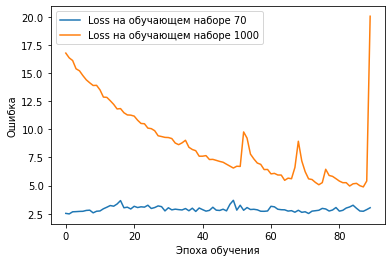

min 70: 2.489996910095215
last 70: 3.038881540298462
min 1000: 4.887869922178132
last 1000: 20.03816760437829


In [ ]:
# Первые 100 эпох
loss1_new = pd.read_csv(NEW_path+'csv/YOLO/loss__el1000_opt0.001__ep0_100.csv')
values_new = loss1_new.values[:, 1]
plt.plot(values_new[10:100], 
         label='Loss на обучающем наборе 70')

loss1 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.001__ep0_100.csv')
values = loss1.values[:, 1]
plt.plot(values[10:100], 
         label='Loss на обучающем наборе 1000')

plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

print ('min 70:', values_new.min())
print ('last 70:', values_new[-1])

print ('min 1000:', values.min())
print ('last 1000:', values[-1])

#### 200 эпох

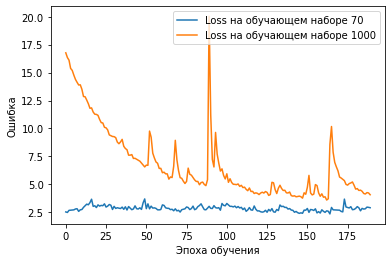

min 70: 2.359023094177246
last 70: 2.913099765777588
min 1000: 3.6010584277766093
last 1000: 4.074403245534215


In [ ]:
# 200 эпох
loss2_new = pd.read_csv(NEW_path+'csv/YOLO/loss__el1000_opt0.001__ep100_200.csv')
values2_new = loss2_new.values[:, 1]
full_loss_new = np.concatenate((values_new, values2_new))
plt.plot(full_loss_new[10:], 
         label='Loss на обучающем наборе 70')

loss2 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.001__ep100_200.csv')
values2 = loss2.values[:, 1]
full_loss = np.concatenate((values, values2))
plt.plot(full_loss[10:], 
         label='Loss на обучающем наборе 1000')

plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

print ('min 70:', full_loss_new.min())
print ('last 70:', full_loss_new[-1])

print ('min 1000:', full_loss.min())
print ('last 1000:', full_loss[-1])

#### 300 эпох

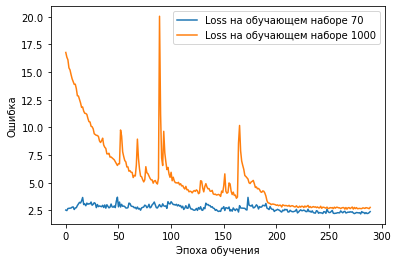

min 70: 2.1892216205596924
last 70: 2.3955187797546387
min 1000: 2.618721180728504
last 1000: 2.7780272683926994


In [ ]:
# 300 эпох
loss3_new = pd.read_csv(NEW_path+'csv/YOLO/loss__el1000_opt0.0001__ep0_100.csv')
values3_new = loss3_new.values[:, 1]
full_loss_new = np.concatenate((full_loss_new, values3_new))
plt.plot(full_loss_new[10:], 
         label='Loss на обучающем наборе 70')


loss3 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.0001__ep0_100.csv')
values3 = loss3.values[:, 1]
full_loss = np.concatenate((full_loss, values3))
plt.plot(full_loss[10:], 
         label='Loss на обучающем наборе 1000')


plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

print ('min 70:', full_loss_new.min())
print ('last 70:', full_loss_new[-1])

print ('min 1000:', full_loss.min())
print ('last 1000:', full_loss[-1])

#### 400 эпох

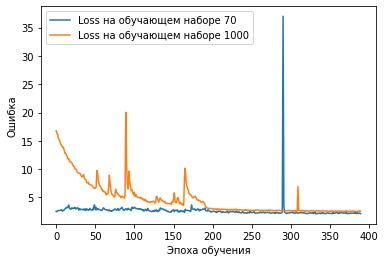

min 70: 2.1013169288635254
last 70: 2.1559705734252934
min 1000: 2.480011485517025
last 1000: 2.5748181151492253


In [ ]:
# 400 эпох
loss4_new = pd.read_csv(NEW_path+'csv/YOLO/loss__el1000_opt0.0001__ep100_200.csv')
values4_new = loss4_new.values[:, 1]
full_loss_new = np.concatenate((full_loss_new, values4_new))
plt.plot(full_loss_new[10:], 
         label='Loss на обучающем наборе 70')

loss4 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.0001__ep100_200.csv')
values4 = loss4.values[:, 1]
full_loss = np.concatenate((full_loss, values4))
plt.plot(full_loss[10:], 
         label='Loss на обучающем наборе 1000')

plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

print ('min 70:', full_loss_new.min())
print ('last 70:', full_loss_new[-1])

print ('min 1000:', full_loss.min())
print ('last 1000:', full_loss[-1])

#### 500 эпох

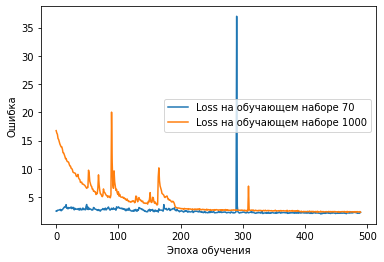

min 70: 2.0350904464721684
last 70: 2.3333606719970703
min 1000: 2.3316804777298654
last 1000: 2.345724961587361


In [ ]:
# 500 эпох
loss5_new = pd.read_csv(NEW_path+'csv/YOLO/loss__el1000_opt0.00001__ep0_100.csv')
values5_new = loss5_new.values[:, 1]
full_loss_new = np.concatenate((full_loss_new, values5_new))
plt.plot(full_loss_new[10:], 
         label='Loss на обучающем наборе 70')

loss5 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.00001__ep0_100.csv')
values5 = loss5.values[:, 1]
full_loss = np.concatenate((full_loss, values5))
plt.plot(full_loss[10:], 
         label='Loss на обучающем наборе 1000')

plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

print ('min 70:', full_loss_new.min())
print ('last 70:', full_loss_new[-1])

print ('min 1000:', full_loss.min())
print ('last 1000:', full_loss[-1])

### **От 200 эпох мы видим что графики идут вместе (не считая выбросов)**

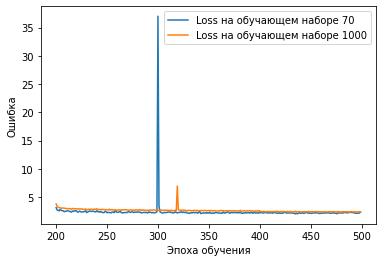

min 70: 2.0350904464721684
last 70: 2.3333606719970703
min 1000: 2.3316804777298654
last 1000: 2.345724961587361


In [ ]:
# От 200 эпох
plt.plot(np.arange(200, 500), full_loss_new[200:], 
         label='Loss на обучающем наборе 70')

plt.plot(np.arange(200, 500), full_loss[200:], 
         label='Loss на обучающем наборе 1000')

plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

print ('min 70:', full_loss_new[200:].min())
print ('last 70:', full_loss_new[-1])

print ('min 1000:', full_loss[200:].min())
print ('last 1000:', full_loss[-1])

**На этом задание Pro закончено. По существу вопроса можно сказать что с укороченной выборкой работать можно. Это дает возможность быстро проверять гипотезы. У нас получилось, что после 200 эпох графики ошибок на полной и укороченной выборке идут практически вместе. По времени двести эпох на короткой выборке обойдутся примерно в 30 минут (вместо ок.7 часов).**

**Ниже посмотрим как распознает картинку модель обученная на коротком наборе.**

In [ ]:
# Набор 70
val_loss1_new = pd.read_csv(NEW_path+'csv/YOLO/valloss__el1000_opt0.001__ep0_100.csv').values[:,1]
val_loss2_new = pd.read_csv(NEW_path+'csv/YOLO/valloss__el1000_opt0.001__ep100_200.csv').values[:,1]
val_loss3_new = pd.read_csv(NEW_path+'csv/YOLO/valloss__el1000_opt0.0001__ep0_100.csv').values[:,1]
val_loss4_new = pd.read_csv(NEW_path+'csv/YOLO/valloss__el1000_opt0.0001__ep100_200.csv').values[:,1]
val_loss5_new = pd.read_csv(NEW_path+'csv/YOLO/valloss__el1000_opt0.00001__ep0_100.csv').values[:,1]
print ('Ошибки на последней эпохе каждого шага:')
print ('100 эпох:', str(round(val_loss1_new[-1], 4)))
print ('210 эпох:', str(round(val_loss2_new[-1], 4)))
print ('300 эпох:', str(round(val_loss3_new[-1], 4)))
print ('400 эпох:', str(round(val_loss4_new[-1], 4)))
print ('500 эпох:', str(round(val_loss5_new[-1], 4)))

Ошибки на последней эпохе каждого шага:
100 эпох: 4.8238
210 эпох: 5.076
300 эпох: 2.2092
400 эпох: 2.2958
500 эпох: 2.1684


In [ ]:
# Набор 1000
val_loss1 = pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.001__ep0_100.csv').values[:,1]
val_loss2 = pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.001__ep100_200.csv').values[:,1]
val_loss3 = pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.0001__ep0_100.csv').values[:,1]
val_loss4= pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.0001__ep100_200.csv').values[:,1]
val_loss5= pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.00001__ep0_100.csv').values[:,1]
print ('Ошибки на последней эпохе каждого шага:')
print ('100 эпох:', str(round(val_loss1[-1], 4)))
print ('210 эпох:', str(round(val_loss2[-1], 4)))
print ('300 эпох:', str(round(val_loss3[-1], 4)))
print ('400 эпох:', str(round(val_loss4[-1], 4)))
print ('500 эпох:', str(round(val_loss5[-1], 4)))

Ошибки на последней эпохе каждого шага:
100 эпох: 324649682.6667
210 эпох: 5.4149
300 эпох: 2.8133
400 эпох: 2.53
500 эпох: 2.591


/content/drive/My Drive/my_sample_data/Д.З.31/Pro100/weights/YOLO/YOLOv3__el1000__opt0.00001__ep0_100.h5 загружены.


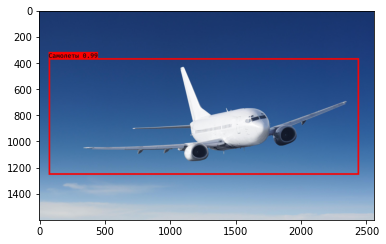

In [ ]:
# Берем картинку из тестовой папки и подаем в функцию
model_weight = NEW_path +'weights/YOLO/YOLOv3__el1000__opt0.00001__ep0_100.h5'
new_img_path = predict_YOLO(path+'test/plane2.jpg', 'first_plane_new.jpg', model_weight)
new_img = Image.open(new_img_path)
plt.imshow(new_img)

/content/drive/My Drive/my_sample_data/Д.З.31/Pro100/weights/YOLO/YOLOv3__el1000__opt0.00001__ep0_100.h5 загружены.


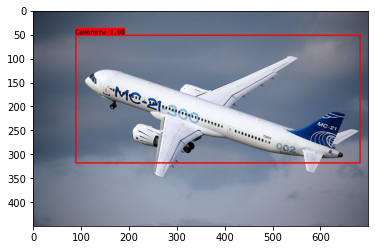

In [ ]:
# Берем картинку из тестовой папки и подаем в функцию
model_weight = NEW_path +'weights/YOLO/YOLOv3__el1000__opt0.00001__ep0_100.h5'
new_img_path = predict_YOLO(path+'test/plane3.jpg', 'first_plane_new.jpg', model_weight)
new_img = Image.open(new_img_path)
plt.imshow(new_img)

**Модель, обученная на укороченном наборе данных, на тестовых данных работает предсказуемо хуже несмотря на низкую ошибку при обучении.**